#### Setup

In [3]:
! pip install wand

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 3.2 MB/s eta 0:00:00 MB/s eta 0:00:01


In [3]:
! brew uninstall imagemagick
! brew install imagemagick@6
! brew unlink imagemagick
! brew link imagemagick@6 --force
! echo 'export MAGICK_HOME="/usr/local/opt/imagemagick@6/lib"' >> ~/.bash_profile
! echo 'export PATH="/usr/local/opt/imagemagick@6/bin:$PATH"' >> ~/.bash_profile

! source ~/.bash_profile

Uninstalling /opt/homebrew/Cellar/imagemagick/7.1.0-51... (805 files, 30.8MB)
==> Downloading https://ghcr.io/v2/homebrew/core/imagemagick/6/manifests/6.9.12-
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/imagemagick/6/blobs/sha256:3681
==> Downloading from https://pkg-containers.githubusercontent.com/ghcr1/blobs/sh
######################################################################## 100.0%
==> Pouring imagemagick@6--6.9.12-66.arm64_monterey.bottle.tar.gz
==> Caveats
imagemagick@6 is keg-only, which means it was not symlinked into /opt/homebrew,
because this is an alternate version of another formula.

If you need to have imagemagick@6 first in your PATH, run:
  echo 'export PATH="/opt/homebrew/opt/imagemagick@6/bin:$PATH"' >> ~/.zshrc

For compilers to find imagemagick@6 you may need to set:
  export LDFLAGS="-L/opt/homebrew/opt/imagemagick@6/lib"
  export CPPFLAGS="-I/opt/homebrew/opt/imagemagick@6

## Font Generation

In [239]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from wand.color import Color
from wand.image import Image
from wand.drawing import Drawing
from wand.compat import nested
import shutil
import pandas as pd

In [240]:
# Charatcters 
language = 'abcdefghijklmnopqrstuvwxyz'
language_upper = language.upper()
language += language_upper
language += '0123456789'

assert len(language) == 26 * 2 + 10 
language = language_upper
language

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [298]:
# Fonts
handwritten_fonts = ['Herculanum', 'Annai MN', 'Bradley Hand', 'Brush Script MT', 'Chalkboard',
             'Comic Sans MS', 'Luminary', 'Noteworthy', 'Papyrus', 'Party LET', 'Savoye LET', 
             'Sign Painter', 'Skia', 'Snell Roundhand', 'Times New Roman', 'Trattatello', 'Zapfino']
typed_fonts = ['Arial', 'Arial Black', 'Arial Narrow', 'Arial Rounded MT Bold', 'Copperplate', 'Courier New', 'Helvetica',
              'Impact', 'Lucinda Grande', 'Microsoft Sans Serif', 'Tahoma', 'Verdana', 'Menlo', 'Didot', 'Copperplate', 'Avenir', 'Futura']

fonts = handwritten_fonts + typed_fonts 
# fonts = ['Chalkboard']

In [299]:
# resolution
width=200
height=200
font_size=100
background = Color('white')
foreground=Color('rgb(0, 0, 0)')

In [300]:
language

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [301]:
def delete(language, language_upper):
    for c in language:
        if c in language_upper:
            if os.path.exists(f'{c}{c}'):
                shutil.rmtree(f'{c}{c}')
        else:
            if os.path.exists(c):
                shutil.rmtree(f'{c}')

In [981]:
def generate(fonts, language, language_upper, width=200, height=200, font_size=100, background=Color('white'), foreground=Color('rgb(0,0,0)')):
    for f in tqdm(fonts):
        for c in language:
            if c in language_upper:
                if not os.path.exists(f'{c}{c}'):
                    os.mkdir(f'{c}{c}')
                filename = os.path.join(f'{c}{c}', f'{f}.png')
            else:
                if not os.path.exists(c):
                    os.mkdir(f'{c}')
                filename = os.path.join(f'{c}', f'{f}.png')

            with Drawing() as draw:
                with Image(width=width, height=height, background=background) as img:
                    draw.font_family = f
                    draw.font_size = font_size
                    draw.push()
                    draw.fill_color = foreground
                    draw.text(0,int(img.height/2), c)
                    draw.pop()
                    draw(img)
                    if os.path.exists(filename):
                        os.unlink(filename)
                    img.save(filename='tmp.png')

                    img = cv2.imread('tmp.png')

                    os.unlink('tmp.png')
                    ys, xs = np.where(np.all(img == (0, 0, 0), axis=-1))
                    
                    if len(ys) > 0 and len(xs) > 0:
                        cropped = img[min(ys):max(ys)+1, min(xs):max(xs)+1]
                        cv2.imwrite(filename, cropped)


In [982]:
generate(fonts, language, language_upper)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:05<00:00,  6.23it/s]


#### Inference

##### Functions

In [958]:
import matplotlib.pyplot as plt
def show(*img):
    for i in img:
        plt.imshow(i, cmap='gray')
        plt.show()
        
def show_rgb(*img):
    for i in img:
        plt.imshow(i, cmap='gray')
        plt.show()

def read(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

def read_rgb(path):
    return cv2.imread(path, cv2.IMREAD_UNCHANGED)

def bin(img, bins=10, min_diff=10):
    count, division = np.histogram(img, bins)
    diff_series = pd.Series(count).diff()
    
    first_histogram_reduction_index = diff_series[(diff_series < 0) & (np.abs(diff_series) > min_diff)].index[0]
    threshold = division[first_histogram_reduction_index+1]
        
    _, img = cv2.threshold(img,threshold,255,cv2.THRESH_BINARY)
    return img

def bin_simple(img, thresh=127):
    img[img >= thresh] = 255
    img[img <= thresh] = 0
    return img
    
def bin2(img):
    return cv2.threshold(img, 0, 255, cv2.THRESH_BINARY +cv2.THRESH_OTSU)[1]

def neg(img):
    return 255 - img

def redraw_contours(img, thickness=16): 
    # Find contours and redraw
    contours, hierarchy = cv2.findContours(image=img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
                                      
    # draw contours on the original image
    image_copy = img.copy()
    cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(255, 255, 255), thickness=thickness, lineType=cv2.LINE_AA)
    return image_copy

def components(img, min_area=800):
    # Connected components
    output = cv2.connectedComponentsWithStats(img, 4, cv2.CV_32S)
    num_letters = output[0]
    letters = output[1]
    stats = output[2]
    centroids = output[3]

    letter_imgs = []
    ## Sort letters + area check
    for l in range(1, num_letters):
        minx = stats[l, cv2.CC_STAT_LEFT]
        maxx = stats[l, cv2.CC_STAT_WIDTH] + minx
        miny = stats[l, cv2.CC_STAT_TOP] 
        maxy = stats[l, cv2.CC_STAT_HEIGHT] + miny
        area = stats[l, cv2.CC_STAT_AREA]
        if area < min_area:
            continue

        cropped_img = img[miny:maxy+1, minx: maxx+1].copy()
        
        # Add negatives directly 
        letter_imgs.append((neg(cropped_img), minx, maxx, miny, maxy))

    # Detect spaces and newlines
    sorted_imgs_y = sorted(letter_imgs, 
       key=lambda x: x[3])

    rectangles = sorted_imgs_y.copy()
    
    from collections import defaultdict
    rows = defaultdict(list)
    row_id = 0
    while len(rectangles) > 0:
        r = rectangles[0]
        rows[row_id].append(r)
        ctr_y = (r[3] + r[4])/2
        rectangles.remove(r)
        
        to_remove = []
        for (img, minx, maxx, miny, maxy) in rectangles:
            # if central y line goes through letter box
            if ctr_y >= miny and ctr_y <= maxy:
                rows[row_id].append((img, minx, maxx, miny, maxy))
                to_remove.append((img, minx, maxx, miny, maxy))
        
        for rem in to_remove:
            rectangles.remove(rem)
            
        row_id+=1
    
    final_result = []
    # for y in text
    for row in range(row_id):
        line = []
        # Search for spaces
        sorted_imgs_x = sorted(rows[row], 
           key=lambda x: x[1])
        
        # for char in line
        word = []
        for i in range(0, len(sorted_imgs_x)-1):
            xmax_first = sorted_imgs_x[i][2]
            xmin_second = sorted_imgs_x[i+1][1]

            prev_letter_width = sorted_imgs_x[i][2] - sorted_imgs_x[i][1]
            next_letter_width = sorted_imgs_x[i+1][2] - sorted_imgs_x[i+1][1]
            dist = (xmin_second - xmax_first)
            
            word.append(sorted_imgs_x[i])
            if dist > max(prev_letter_width, next_letter_width):
                line.append(word)
                word = []
        
        # Assume no space at end of line
        word.append(sorted_imgs_x[-1])
        line.append(word)
        final_result.append(line)
    
    return final_result

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def resize(img, size=(100, 100)):
    return cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)

def erode(img, it=1):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.erode(img, kernel, iterations=it)

def dilate(img, it=1):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.dilate(img, kernel, iterations=it)

def blur(x):
    return cv2.GaussianBlur(x, (3, 3), cv2.BORDER_DEFAULT)

In [967]:
def bin_2(path):
    x = read(path)
    y = cv2.Laplacian(x, cv2.CV_16S, ksize=3)

    # Binarize
    z = y.copy()
    z[z > 127] = 255
    z[z <= 127] = 0
    return z

def pipeline_2(path, show_steps=False):
    z = bin_2(path)
    
    # Thicken letters
    q = dilate(z, it=3).astype(np.uint8)
    
    # Find components
    lines = components(q)

    if show_steps:
        show(x)
        show(y)
        show(z)
        show(q)
        for line in lines:
            for word in line:
                for c in word:
                    show(c[0])
            
    return lines

### NN

In [1247]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

#### Model

In [1289]:
tf.keras.utils.set_random_seed(0)

## Augment Data
size = 64
epochs = 10

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(language), activation='softmax'))
model.summary()


import glob

image_paths = sorted(glob.glob("*/*.png"))
train_labels = np.array(list(range(26)))
classes = sorted(set([i[:i.index('/')] for i in image_paths]))
classes_fmap = dict(zip(classes, train_labels))
classes_imap = dict(zip(train_labels, classes))

train_images = [resize(read(x), size=(size, size))//255 for x in image_paths]
train_labels = np.stack([classes_fmap[i[:i.index('/')]] for i in image_paths])
train_images = np.stack(train_images)


Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_219 (Conv2D)         (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_143 (MaxPooli  (None, 31, 31, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_220 (Conv2D)         (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_144 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_221 (Conv2D)         (None, 12, 12, 64)        36928     
                                                                 
 flatten_55 (Flatten)        (None, 9216)            

#### Data

In [ ]:
hstacks = []
np.random.seed(0)
for _ in range(10):
    idx = np.random.choice(len(train_images), 10)
    sample = train_images[idx]
    hstacks.append(np.hstack(sample))
    
plt.figure(figsize=(20, 20))
show(np.vstack(hstacks))

#### Augmentation

In [1299]:
def augment(train_images, train_labels, 
            dilate_depth=1, 
            erode_depth=2,
            r_from=-5,
            r_to=5,
            r_step=5):
    res_images = []
    res_labels = []
    for i in range(train_images.shape[0]):
        img = train_images[i]
        l = train_labels[i]

        # rotation
        # negate for black background
        x = neg(img * 255)
        
        # First, expand the image and translate to center
        new_shape = (int(x.shape[0]*1.43), int(x.shape[1]*1.43))
        tx = (new_shape[0] - x.shape[0])/2
        ty = (new_shape[1] - x.shape[1])/2
        M = np.float32([[1,0,tx],[0,1,ty]])
        dst = cv2.warpAffine(x,M,x.shape)

        translated = cv2.warpAffine(x, M, new_shape)
        
        cx = translated.shape[0]/2
        cy = translated.shape[1]/2
        for d in range(r_from, r_to+1, r_step):
            M = cv2.getRotationMatrix2D((cx, cy),d,1) 
            rotated = cv2.warpAffine(translated, M, (int(x.shape[0]*1.43), int(x.shape[0]*1.43)))
            
            # Reverse negation
            rotated = neg(rotated)
            res_images.append(rotated)
            res_labels.append(l)
                  
            # erosion
            for it in range(1, erode_depth+1):
                rotated_and_eroded = erode(rotated, it=it)
                res_images.append(rotated_and_eroded)
                res_labels.append(l)

            # dilation
            for it in range(1, dilate_depth+1):
                rotated_and_dilated = dilate(rotated, it=it)
                res_images.append(rotated_and_dilated)
                res_labels.append(l)
        
        
    cropped_images = []
    for r in res_images:
        ys, xs = np.where(r==0)

        if len(ys) > 0 and len(xs) > 0:
            cropped = r[min(ys):max(ys)+1, min(xs):max(xs)+1]
            resized = resize(cropped, (size, size))
            if resized.shape[0] > 0:
                cropped_images.append(resized)
        
    return np.stack(cropped_images)//255,np.array(res_labels)  

Total images for training:  17986


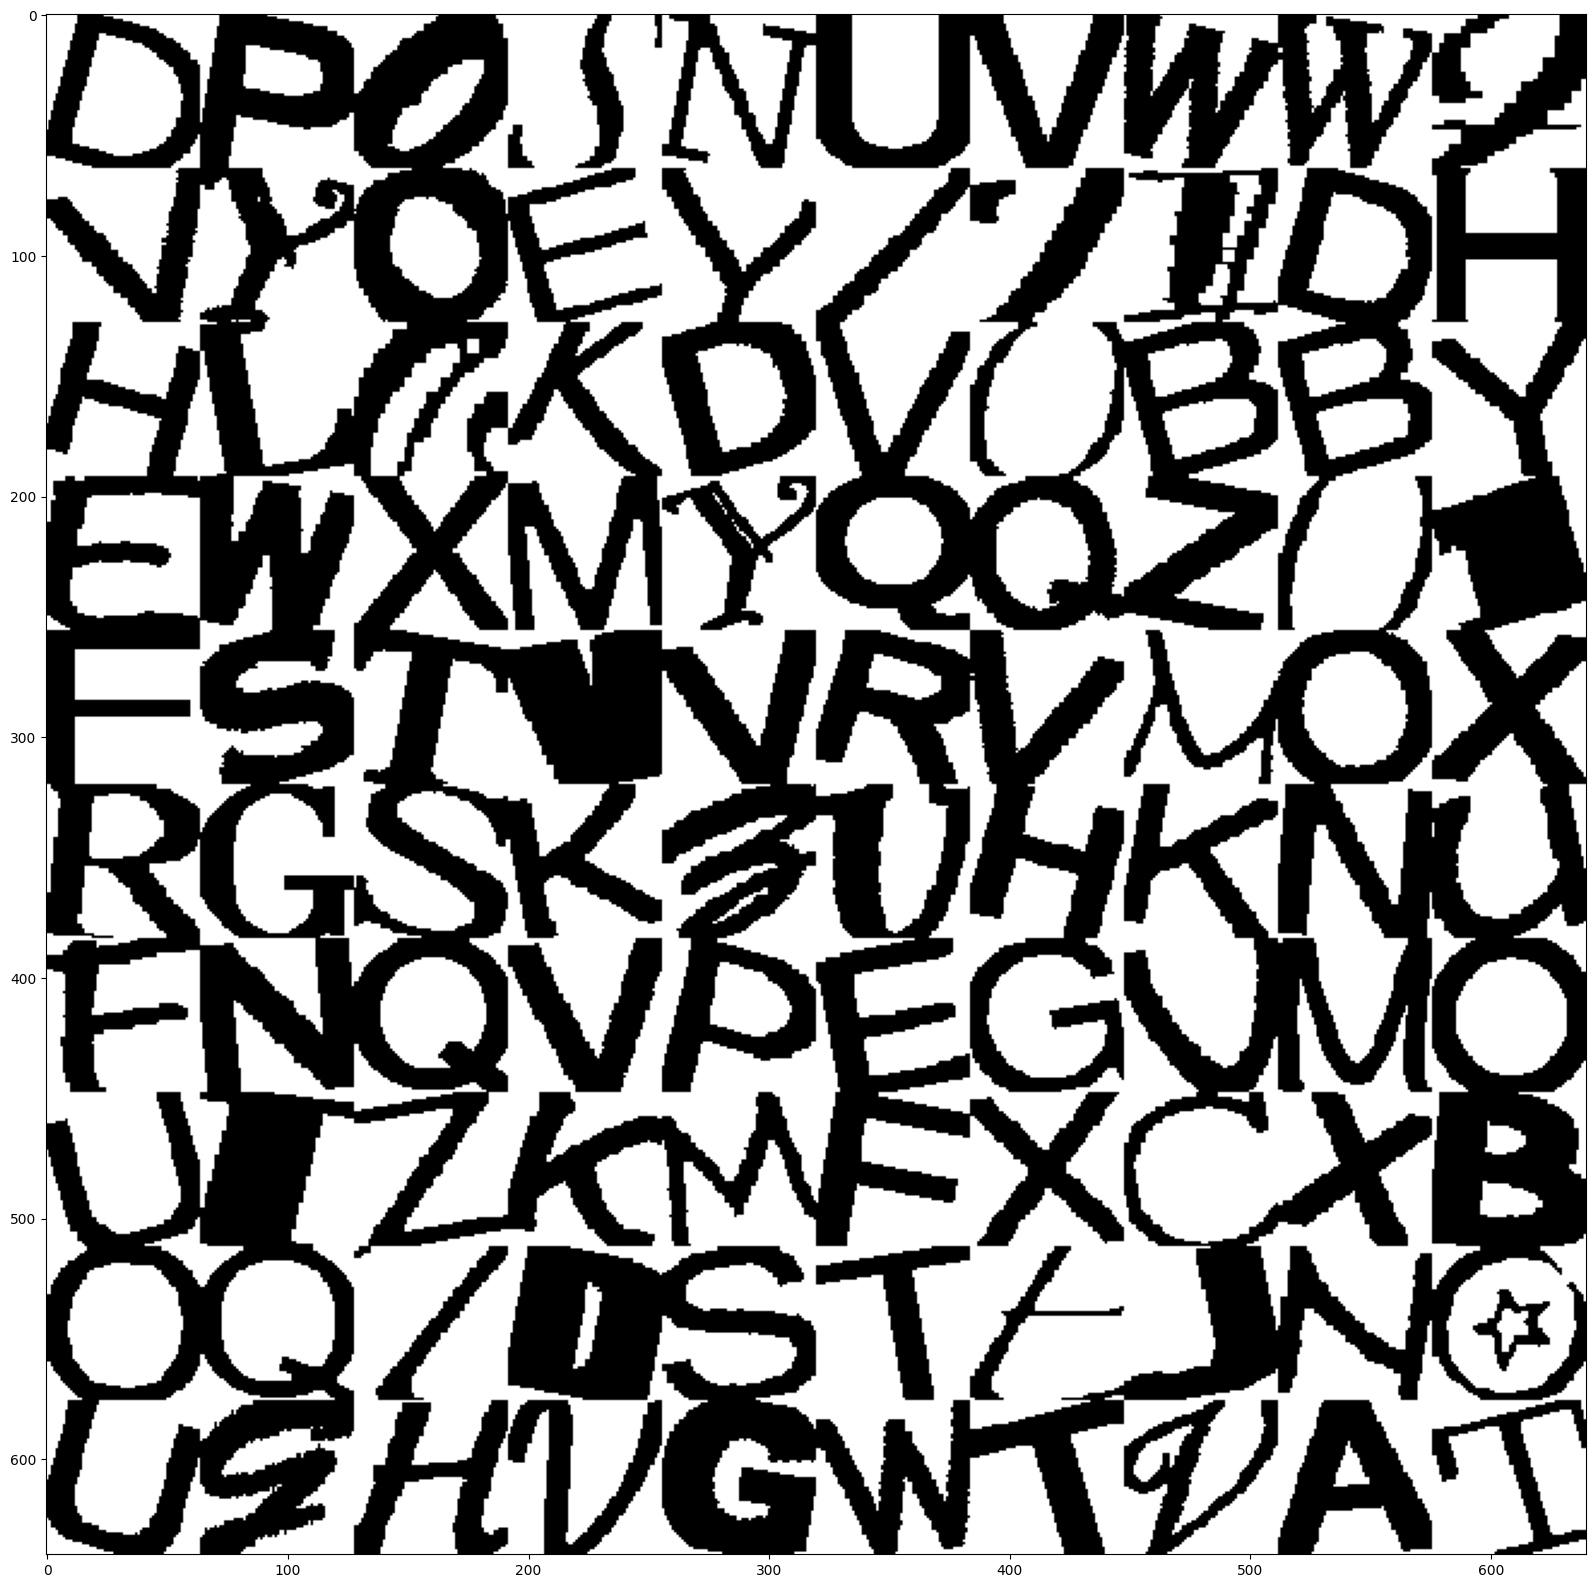

In [1300]:
# Augment images 
erode_depth = 1
dilate_depth = 1
r_from = -15
r_to = 16
r_step = 5
train_images_augmented, train_labels_augmented = augment(train_images, train_labels, 
                                                         erode_depth=erode_depth, 
                                                         dilate_depth=dilate_depth,
                                                         r_from=r_from,
                                                         r_to=r_to,
                                                         r_step=r_step)
print('Total images for training: ', len(train_images_augmented))

plt.figure(figsize=(20, 20))

hstacks = []
np.random.seed(0)
for _ in range(10):
    idx = np.random.choice(len(train_images_augmented), 10)
    sample = train_images_augmented[idx]
    hstacks.append(np.hstack(sample))
    
show(np.vstack(hstacks))


In [1301]:
# Shuffle
idx = np.random.permutation(len(train_images_augmented))
train_images_augmented, train_labels_augmented = train_images_augmented[idx], train_labels_augmented[idx]
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(train_images_augmented, train_labels_augmented, 
                    epochs=epochs)


Epoch 1/10
563/563 [==============================] - 15s 27ms/step - loss: 0.7145 - accuracy: 0.8250
Epoch 2/10
563/563 [==============================] - 16s 28ms/step - loss: 0.2409 - accuracy: 0.9425
Epoch 3/10
563/563 [==============================] - 16s 28ms/step - loss: 0.1676 - accuracy: 0.9611
Epoch 4/10
563/563 [==============================] - 16s 28ms/step - loss: 0.1379 - accuracy: 0.9674
Epoch 5/10
563/563 [==============================] - 15s 27ms/step - loss: 0.1155 - accuracy: 0.9723
Epoch 6/10
563/563 [==============================] - 15s 27ms/step - loss: 0.1055 - accuracy: 0.9745
Epoch 7/10
563/563 [==============================] - 15s 27ms/step - loss: 0.1001 - accuracy: 0.9753
Epoch 8/10
563/563 [==============================] - 16s 28ms/step - loss: 0.1012 - accuracy: 0.9748
Epoch 9/10
563/563 [==============================] - 15s 27ms/step - loss: 0.0938 - accuracy: 0.9762
Epoch 10/10
563/563 [==============================] - 15s 27ms/step - loss: 0.092

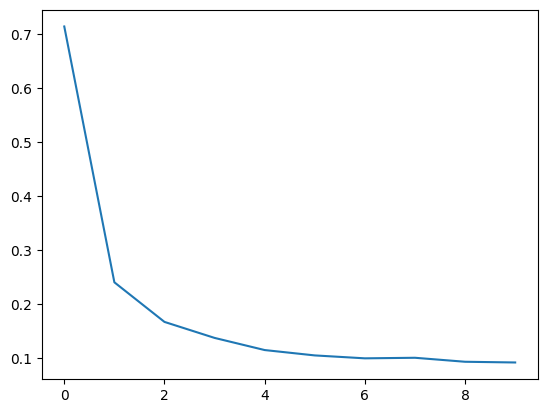

<AxesSubplot: >

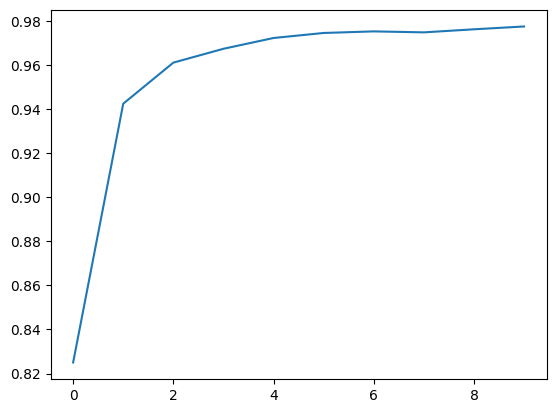

In [1302]:
pd.Series(history.history['loss']).plot()
plt.show()
pd.Series(history.history['accuracy']).plot()

In [1303]:
def classify_nn_augmented(letter_img, inference_size=(size, size), _filter='.png'):
    # Add dilation to inference
    cx = letter_img.shape[0]/2
    cy = letter_img.shape[1]/2
    all_imgs = []
    all_imgs.append(letter_img)
    for d in range(r_from, r_to, r_step):
        M = cv2.getRotationMatrix2D((cx, cy),d,1) 
        rotate = neg(cv2.warpAffine(neg(letter_img),M, x.shape))
        all_imgs += [dilate(rotate, it=i) for i in range(1, dilate_depth)]
        all_imgs += [erode(rotate, it=i) for i in range(1, erode_depth)]
    
    characters = []
    for i, letter_img in enumerate(all_imgs):
        letter_img_res = bin(resize(letter_img, inference_size))//255
        letter_img_tensor = np.stack([letter_img_res])

        results = model.predict(letter_img_tensor, verbose=False)
        char_idx = np.argmax(results)
        character = classes_imap[char_idx][0]
        characters.append({'char': character, 'dilate_it': i, 'result': np.max(results)})
        
    characters = pd.DataFrame(characters)
    return characters['char'].mode().values[0]

def classify_nn(letter_img, inference_size=(size, size), _filter='.png'):
    letter_img_res = bin(resize(letter_img, inference_size))//255
    letter_img_tensor = np.stack([letter_img_res])
        
    results = model.predict(letter_img_tensor, verbose=False)
    char_idx = np.argmax(results)
    character = classes_imap[char_idx][0]
    return character, results

def ocr(path, show_steps, class_fn):
    lines = pipeline_2(path, show_steps=show_steps)
    text = ''
    for line in lines:
        for word in line:
            for c, *_ in word:
                char = class_fn(c)[0]
                text += char
            text += ' '
        text += '\n'
    return text

def ocr_nn(path, show_steps=False):
    return ocr(path, show_steps, classify_nn)
    
    
def ocr_nn_augmented(path, show_steps=False):
    return ocr(path, show_steps, classify_nn_augmented)

#### Tests NN

In [1304]:
ocr_nn('test.png')

'TEST \n'

In [1305]:
ocr_nn_augmented('test.png')

'TEST \n'

In [1308]:
results = {}
fns = [ocr_nn, ocr_nn_augmented]
# fns = [ocr_nn]
tests = [x for x in os.listdir('.') if x.endswith('.png') or x.endswith('.jpg')]
for fn in fns:
    num_correct = 0
    num_total = 0
    
    for t in tests:
        label = t[:t.index('.')].upper()
        num_total += len(label)

        result = ''.join(fn(t))
        for i in range(min(len(label), len(result))):
            if label[i] == result[i]:
                num_correct+=1
        print(t, result)
        
    results[fn] = num_correct/num_total
results

team.png TEAN 

fmi.png FMI 

tactical.png TACTICAL 

ocr.png OCR 

test.png TEST 

processing.png PROCESSLNG 

team.png TEAN 

fmi.png FMI 

tactical.png TACTICAL 

ocr.png OCR 

test.png TEST 

processing.png PROCESSLNG 



{<function __main__.ocr_nn(path, show_steps=False)>: 0.9375,
 <function __main__.ocr_nn_augmented(path, show_steps=False)>: 0.9375}

### Tests multiline

In [1310]:
r = ocr_nn('mazalo.mpng')
print(r)

TQTAL SHTETA 
LESHTA BOZ 
MAZZALLO 



In [1311]:
r = ocr_nn('multiline.mpng')
print(r)

FMI 
INAGE 
PROGESSLNG 

